In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import sklearn as sk
import os
import random
import math

In [2]:
tf.test.is_built_with_cuda()

True

**Constants**


In [3]:
IMG_SIZE = 224


#PATH = "C:/Python/chen22/hitting_behaviors/video_data/violence_dataset/"
PATH = "video_data/violence_dataset/"

**Data Preprocessing**


In [4]:
def video_to_frames(p):
    #assert os.path.exists(p)
    cap = cv2.VideoCapture(p)
    
    #assert cap
    rate = math.floor(cap.get(3))

    ImageFrames = []
    #assert cap.isOpened()
    

    '''make sure to figure out how to extract a certain amount of frames so you don't use too much memory'''
    while cap.isOpened():
        #ID = cap.get(1)
        
        success, image = cap.read()
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        #print(n_frames)
        #assert success

        if success:

            for frame in range(n_frames):
                if frame % 10 == 0:
                    
                    
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    ImageFrames.append(image)
                else: continue
            cap.release()
    #print("successful frame capture")
            return ImageFrames

        else: 
            break

In [5]:
CATEGORIES = ["NonViolence", "Violence"]
X_set = []
y_set = []
for category in os.listdir(PATH):
    
    
    path = os.path.join(PATH, category)
    #print(path)
    #assert os.path.exists(path)


    class_num = CATEGORIES.index(category)
    for i, video in tqdm(enumerate(os.listdir(path)[0:350]), total=len(os.listdir(path)[0:350])):

        #print(path + '/' + video)
        #print(os.path.join(path, video))
        frames = video_to_frames(path + '/' + video)
        if frames:
        
            for j, frame in enumerate(frames):
                X_set.append(frame)
                y_set.append(class_num)
        else: continue

            
print("success")

100%|██████████| 350/350 [00:07<00:00, 47.19it/s]

success


In [6]:
X_set = np.array(X_set).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_set = np.array(y_set)
len(X_set), len(y_set)

(9878, 9878)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

#X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

#X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state=42)

In [8]:
print(f" X_train shape: {X_train.shape}, X_train data type: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}")

 X_train shape: (7902, 224, 224, 3), X_train data type: float64
y_train shape: (7902,)


In [9]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train[0:5000], y_train[0:5000], 16)
test_gen = DataGenerator(X_test, y_test, 16)


In [10]:
# tf_X_train = tf.convert_to_tensor(X_train[0:5000], dtype=tf.float32)
# tf_X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


# tf_y_train = tf.convert_to_tensor(y_train[0:5000], dtype=tf.float32)
# tf_y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [11]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0:4000], y_train[0:4000]))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
# BATCH_SIZE = 16
# SHUFFLE_BUFFER_SIZE = 100

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

**Building Model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [14]:
from tensorflow.keras import Sequential, layers

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation"
)

In [19]:
def build_model(input_shape, data_aug, trainable=True, dropout=0.2):
        inputs = keras.Input(shape=input_shape)
        x = data_aug(inputs)
        x = preprocess_input(x)

        baseModel = EfficientNetV2B0(weights=None, include_top=False, input_tensor=x)
        baseModel.trainable = trainable

        headModel = baseModel.output
        headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = Model(inputs, outputs)

        return model

In [20]:
# EffNet = tf.keras.applications.EfficientNetV2B0(include_top=True,
#                                                 weights=None,
#                                                 pooling='avg', 
#                                                 classes=1)
# #EffNet.trainable = False


EffNet = build_model(input_shape=(224,224) + (3,),
                     data_aug= data_augmentation,
                     trainable=True,
                     dropout=0.2)

Compile model

In [21]:
EffNet.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

            

In [22]:
gpus = tf.config.list_physical_devices('GPU')

print(gpus)

print("Num Physical Devices Available: ", len(gpus))

print(tf.__version__)
print(cv2.__version__)

if gpus:
      # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num Physical Devices Available:  1
2.8.0
4.6.0
1 Physical GPUs, 1 Logical GPU


Fit model

In [23]:
history = EffNet.fit(train_gen,
                     batch_size=16,
                     epochs=11,                     
                     verbose=1)

print("Training Complete.")

Epoch 1/11
313/313 [==============================] - 127s 307ms/step - loss: 0.5977 - accuracy: 0.6802
Epoch 2/11
313/313 [==============================] - 34s 109ms/step - loss: 0.4891 - accuracy: 0.7712
Epoch 3/11
313/313 [==============================] - 34s 110ms/step - loss: 0.3912 - accuracy: 0.8328
Epoch 4/11
313/313 [==============================] - 34s 110ms/step - loss: 0.3371 - accuracy: 0.8574
Epoch 5/11
313/313 [==============================] - 34s 110ms/step - loss: 0.2826 - accuracy: 0.8860
Epoch 6/11
313/313 [==============================] - 34s 110ms/step - loss: 0.2470 - accuracy: 0.9040
Epoch 7/11
313/313 [==============================] - 35s 110ms/step - loss: 0.2088 - accuracy: 0.9150
Epoch 8/11
313/313 [==============================] - 35s 110ms/step - loss: 0.1976 - accuracy: 0.9238
Epoch 9/11
313/313 [==============================] - 35s 113ms/step - loss: 0.1619 - accuracy: 0.9350
Epoch 10/11
313/313 [==============================] - 36s 114ms/step - 

In [24]:
def eval_model(model):
    acc = model.evaluate(test_gen)
    print("This model's accuracy is:", round(acc[1], 4)*100 , "%")


eval_model(EffNet)

124/124 [==============================] - 6s 33ms/step - loss: 1.0985 - accuracy: 0.4970
This model's accuracy is: 49.7 %


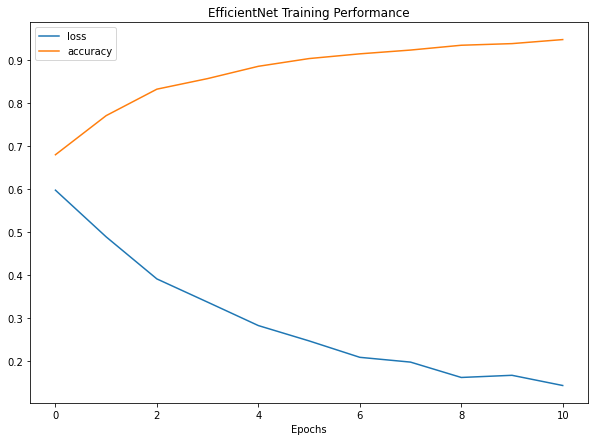

In [25]:
def view_performance(model_hist):
    graph = pd.DataFrame(model_hist.history).plot(figsize=(10,7), title="EfficientNet Training Performance", xlabel="Epochs")



view_performance(history)